# Алгоритмы на основе деревьев решений

Пусть у нас задано обучающее множество пар объектов и ответов к ним $Q=\{(x, y)\}$, где $x ∈ X$ - вектора из $\mathbb{R}^M$, описываемые $M$ координатами (признаками), $y ∈ Y$ - целевая метка объекта, $|Q|=N$. Множество $Y$ может быть непрерывным (задача регрессии) с мощность $|Y|=N$ или дискретным (задача классификации) с мощностью $|Y|=K$, где $K$ - количество классов.

Наша с вами цель - составить такую функцию $f(x)$ - модель, которая наилучшим образом определяет зависимость между векторами x из множества $X$ и целевой переменной $y$ из множества $Y$   $f:X \Rightarrow Y$. 

Строго говоря, такую функцию мы будем искать не в аналитическом виде, как мы делали, например, в случае линейной регрессии, а в виде алгоритма, то есть в виде последовательности действий. Обычно в математике алгоритм обозначается как $a(x)$ или $a: X \Rightarrow Y$.


Алгоритм $a(x)$ мы будем искать в семействе деревьев решений. 

## Деревья решений. Алгоритм CART

**CART (Classification and Regression Tree)** - алгоритм и предназначенный для построения бинарных деревьев решений (деревьев, у которых каждая вершина связана с двумя другими вершинами нижнего уровня). Алгоритм очень похож на C4.5, однако в отличие от последнего предназначен как для задач классификации, так и для задач регрессии. CART важен для нас поскольку, именно он используется для построения моделей решающих деревьев в sklearn.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

### Алгоритм CART: параметры разбиения

Решаем задачу построения решающего пня: дерева с глубиной 1.

Будем рассматривать простые предикаты вида:
$$B(x_j, t)=[x_j \leqslant t]$$
Введем некоторую меру неоднородности $G(X, y, w)$, которая будет  показывать, насколько большой разброс целевой переменной $y$ для объектов из множества $X$ наблюдается в дочерних вершинах при параметрах сплита $w$. 

Параметры $w=(j, t)$ можно найти простым перебором. В качестве кандидатов на пороговое значение $t$ можно рассматривать среднее значение между двумя соседними уникальными значениями отсортированного фактора $x_j$. 

Для каждого из возможных предикатов $B(x_j, t)$ нам необходимо подсчитать значение неоднородности $G(X, y,w)$ на всей выборке и определить такую комбинацию $w_{opt}=(j_{opt}, t_{opt})$, которая дает минимум:

$$w_{opt} = argmin_w(G(X, y, w))$$

Псевдокод алгоритма поиска оптимальных параметров:
```
min_loss = inf
optimal_split_params = None
for j in range(M):
    thresholds = find_candidates_for_thresholds(X[:, j], y)
    for t in thresholds:
        split_params = (j, t)
        loss = calculate_loss(X, y, split_params)
        if loss < min_loss:
            min_loss = loss
            optimal_split_params = split_params
```

Алгоритм поиска кандидатов в параметры разбиения:
1. Сортировать числовой фактор $x_j$ по возрастанию:
$$\{x_{ij} | x_{ij}<x_{(i+1)j}\} $$
2. Вычислить среднее между двумя соседними уникальными значениями фактора:
$$\{x_{ij}^{mean}| x_{ij}^{mean}=\frac{(x_{ij}+x_{(i+1)j})}{2}\}$$
3. В качестве кандидатов на пороговые значений t выбираются только те значения, при которых целевой признак меняет свое значение.
$$\{x_{ij}^{mean}| y_i-y_{(i+1)} \neq 0\}$$ 


In [2]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']
x = x.sort_values().drop_duplicates()
x_roll_mean = x.rolling(2).mean()
x_roll_mean = x_roll_mean.dropna()
y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
candidates

2    17.5
3    19.0
7    22.5
9    30.0
4    34.5
5    43.5
Name: age, dtype: float64

In [3]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(data['age'], data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


Задание 3.4 Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)
Найдите уникальных кандидатов на пороговое значение  для фактора  (Lot Frontage).

In [4]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [5]:

print(find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


In [6]:

print(find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice']))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


### Алгоритм CART: неоднородность, критерии информативности

Пары объектов $x$ и ответов $y$, соответствующих им, обозначим одной буквой $Q=\{(x, y)\}$. Пусть это множество $Q$ содержит $N=|Q|$ объектов из обучающей выборки.

Введем функцию **критерия информативности (критерий неоднородности)** $H(Q)$, которая показывает разброс ответов $y$ в обучающей выборке $Q$.

Предположим, что мы выбрали какие конкретные параметры $w$, тогда множество $Q$ разбивается на две части: $Q^{left}=(X^{left} ,y^{left})$ и $Q^{right}=(X^{right} ,y^{right})$, для которых условие предиката $B(x_j,t)$ выполняется и не выполняется соответственно:
 
$$Q^{left}=\{(x, y)| x_{j} \leqslant t\}$$

$$Q^{right}=Q - Q^{left}=\{(x, y)| x_j>t\}$$
 
Каждая из полученных выборок будет иметь свои размеры - мощности множеств, назовем их как $N^{left}=|Q^{left}|$ и $N^{right}=|Q^{right}|$.
Введем понятие **взвешенной неоднородности**:
$$G(Q, w) = \frac{N^{left}}{N} H(Q^{left}) + \frac{N^{right}}{N} H(Q^{right})  \Rightarrow min_{w}$$

$$w_{opt} = argmin_w(G(Q, w))$$

Тогда **прирост информации (information gain)** будет выражаться как: 
 
$$IG(Q, w)=H(Q)-G(Q, w)=H(Q)- \frac{N^{left}}{N} H(Q^{left})-\frac{N^{right}}{N} H(Q^{right})$$

#### Критерии информативности регрессии:
* **squared error:**
$$H(Q)=\frac{1}{N} \sum_{y∈ Q} (y-\hat{y})^2 = \frac{1}{N} \sum_{y∈ Q} (y-\overline{y})^2 $$
$$\overline{y} = \frac{1}{N} \sum_{y∈ Q}y$$

* **absolute error:**
$$H(Q)=\frac{1}{N} \sum_{y∈ Q} |y-\hat{y}| = \frac{1}{N} \sum_{y∈ Q} |y-median(y)| $$

* **poisson:**

$$H(Q)=\frac{1}{N} \sum_{y∈ Q} (y log (\frac{y}{\overline{y}} - y + \overline{y}) $$

#### Критерии информативности классификации:

Вероятность принадлежности к классу под номером $k$: 
 
$$P_k=\frac{1}{N}\sum_{y∈ Q}[y=k]$$

* **entropy:**
$$H(Q)=-\sum_{k=1}^{K} P_k log(P_k)$$

* **gini:**

$$H(Q)=\sum_{k=1}^{K}P_k(1-P_k)$$

In [7]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [8]:
# Создаем обучающую выборку
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 5.5


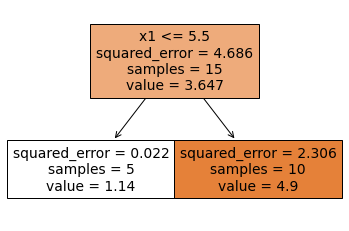

In [9]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [10]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data["Lot Frontage"] <= 150) & (ames_data["Lot Area"] <= 20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)
X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

In [11]:

# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0


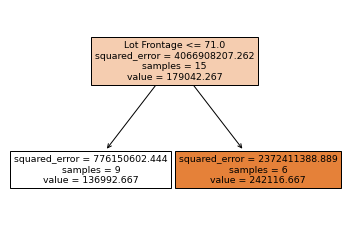

In [12]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [13]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

In [14]:
optimal_params = best_split(X, y, criterion=entropy)
optimal_params

(0, 65.0)

Задание 4.5
3/3 points (graded)

Дана часть датасета о банкнотах, состоящая из 15 наблюдений:


Найдите оптимальные для построения решающего пня параметры разбиения  и . Для этого воспользуйтесь функцией best_split(), которую мы реализовали ранее. В качестве критерия информативности используется энтропию Шеннона.

In [15]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [16]:
optimal_params = best_split(X, y, criterion=entropy)
optimal_params

(1, 3.22085)

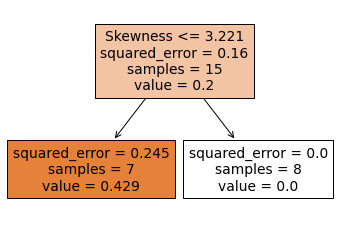

In [17]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

### Алгоритм CART: рекурсия, критерии остановки

Итак, пусть $Q_v=\{(x, y)\}$ - множество объектов и ответов к ним, попавших в вершину с номером $v$, $N_v=|Q_v|$. Пусть задан критерий информативности $H(Q)$, который зависит от задачи (регрессия - squared error, absolute error или poisson, классификация - gini или entropy).
 
А также задан некоторый критерий остановки рекурсии $stop\_criterion(Q_v)$. 

Наш алгоритм построения дерева решений CART будет выглядеть следующим образом:
1. Создаем вершину под номером $v$
2. Проверяем критерий остановки $stop\_criterion(Q_v)$ <p>
    2.1. Если условие выполнено.
    Формируем листовую вершину $v$ и ставим в соответствие этому листу ответ $\hat{y_v}$, который будет выдаваться для новых объектов, которые дойдут до этого листа. Назовем эту часть $create\_leaf()$.
    * Регрессия:
    $$\hat{y_v}=\frac{1}{N_v}\sum_{y ∈ Q_v}y$$
    $$или$$
    $$\hat{y_v}={median}_{y ∈ Q_v}(y)$$
    * Классификация:
    $$P_{vk}=\frac{1}{N_v}\sum_{y ∈ Q_v}[y=k],$$
    $$\hat{y_v}=argmax_{k∈K}(P_{vk})$$
    2.2. Если условие остановки не выполнено.
    Строим решающий пень. Формируем решающее правило $B(x_j, t)$ для вершины $v$. Из возможных комбинаций $w=(j, t)$ находим такую, которая определяет наилучшее разбиение текущего множества объектов и ответов к ним $Q_v$
    $$G(Q, w) = \frac{N_v^{left}}{N_v} H(Q_v^{left}) + \frac{N_v^{right}}{N} H(Q_v^{right})  \Rightarrow min_{w}$$
    
    $$w_{opt} = argmin_w(G(Q_v, w))$$
    
    $$B_v(x_j, t) = [x_{j_{opt}} \leqslant t_{opt}]$$
    Для выборок $Q_v^{left}$ и $Q_v^{right}$ процедура будет повторяться рекурсивно, пока не выполнится критерий остановки.
3. Возвращаем созданную вершину

In [18]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
# Создаем обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


In [19]:
# Создаем модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Печатаем дерево решений в виде списка условий
print(tree.export_text(decision_tree=dt))

|--- feature_0 <= 43.50
|   |--- feature_1 <= 86.00
|   |   |--- feature_0 <= 22.50
|   |   |   |--- feature_0 <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  19.00
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  22.50
|   |   |   |--- class: 1
|   |--- feature_1 >  86.00
|   |   |--- class: 0
|--- feature_0 >  43.50
|   |--- class: 0



In [20]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)  

def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

# Предсказываем целевую переменную
y_pred = predict(decision_tree, X)
print('Predictions: {}'.format(y_pred))

Predictions: [1 0 1 0 1 0 0 1 1 0]


В реализации дерева решений в sklearn предусмотрено несколько критериев при выполнении одного из которых ветвление дерева прекращается:
* Достижения однородности (основной критерий)
* Ограничение максимальной глубины дерева (параметр max_depth)
* Ограничение на максимальное количество листьев в дереве (параметр max_leaf_node)
* Ограничение на минимальное количество объектов, при которых допускается ветвление дерева (параметр min_samples_split)
* Ограничение на минимальное количество объектов, необходимых для создания листа (параметр min_samples_leaf)

In [21]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_rigth, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

# Строим дерево решений с ограничением глубины и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


In [23]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [25]:
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0


### Алгоритм CART: значимость признаков

Прирост информации: 
$$IG(Q_v, w)=H(Q_v)-G(Q_v, w)=H(Q_v)- \frac{N_v^{left}}{N_v} H(Q_v^{left})-\frac{N_v^{right}}{N_v} H(Q_v^{right})$$
или:
$$IG(Q_v, w)= {N_v} H(Q_v) - {N_v^{left}} H(Q_v^{left})- {N_v^{right}} H(Q_v^{right})$$

Тогда значимость **(абсолютная)** признаков будет определяться как:
$$F(x_j)=\frac{1}{N} \sum_{v ∈ V_j}IG(Q_v, w)$$

Нормируем полученные соотношения и получим **относительную** значимость:
$$\overline{F(x_j)}=\frac{F(x_j)}{\sum_{j =1}^M F(x_j)}$$

In [22]:
def calculate_feature_importances(node, feature_importance=None):
    if feature_importance is None:
        feature_importance = np.zeros(X.shape[1])
    if node.value is None:
        j = node.split_params[0]
        feature_importance[j] += node.impurity * node.samples - \
                                 node.left.impurity * node.left.samples - \
                                 node.right.impurity * node.right.samples
        calculate_feature_importances(node.left, feature_importance)
        calculate_feature_importances(node.right, feature_importance)
    feature_importance /= node.samples
    feature_importance /= feature_importance.sum()
    return feature_importance

# Создаем обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, entropy)
# Считаем информативности признаков
print(calculate_feature_importances(decision_tree))

[0.78582905 0.21417095]


Практика

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [28]:
voice_data = pd.read_csv('data/voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [29]:
voice_data.isnull().sum().sum()

0

In [38]:
# Создаём обучающую выборку
X = voice_data.drop(columns=['label'])
y = voice_data['label']

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


7.1 Начнём с решающего пня.

Создайте модель дерева решений максимальной глубины 1. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.




Accuracy: 0.956


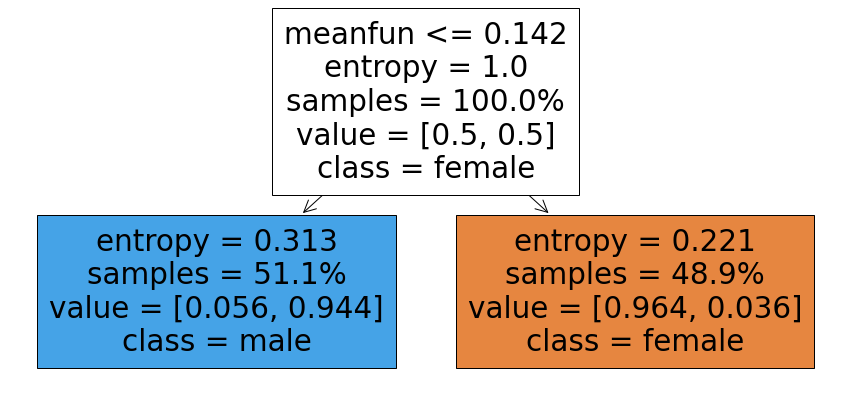

In [42]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy' #критерий информативности
)
dt.fit(X_train, y_train)

# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

7.2 Увеличим глубину дерева.

Создайте дерево решений с максимальной глубиной 2. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

Accuracy: 0.962


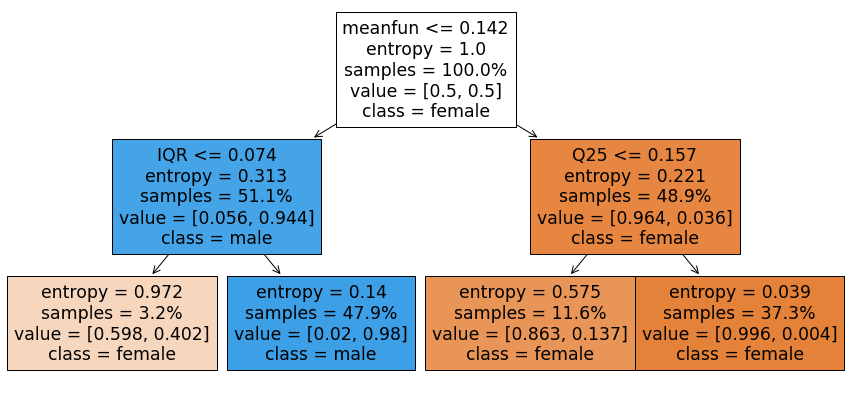

In [43]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=2, #глубина
    criterion='entropy', #критерий информативности
    random_state=42
)
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

7.3 Давайте дадим дереву решений полную свободу.

Создайте дерево решений, не ограничивая его максимальную глубину. В качестве критерия информативности используйте энтропию Шеннона.

В качестве значения параметра random_state возьмите 0.



In [44]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)
print('Depth: {}'.format(dt.get_depth()))
print('Count of leaves: {}'.format(dt.get_n_leaves()))
# Делаем предсказание
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на обучающей и тестовой выборках
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Depth: 12
Count of leaves: 54
Train accuracy: 1.000
Test accuracy: 0.973


7.4 Давайте попробуем найти оптимальные внешние параметры модели дерева решений для поставленной задачи. Воспользуемся классическим методом подбора гиперпараметров — перебором на сетке с кросс-валидацией (Grid SearchCV).

In [45]:
# Задаем сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], #критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], #максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] #минимальное количество объектов, необходимое для сплита
}

# Задаем метод кросс-валидации
cv = model_selection.StratifiedKFold(n_splits=5)

# Инициализируем поиск на сетке и обучаем его
gs = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=0), #модель
    param_grid=param_grid, #сетка параметров
    scoring='accuracy', #метрика
    cv=cv, #кросс-валидатор
    n_jobs=-1 #используем все мощности процессора
)
gs.fit(X_train, y_train)
print(gs.best_params_)
# Определяем наилучшую модель
best_tree = gs.best_estimator_

# Делаем предсказание
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)
# Считаем метрику accuracy на обучающей и тестовой выборках
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}
Train accuracy: 0.996
Test accuracy: 0.970


7.5  Для оптимального дерева решений, построенного в задании 7.4, найдите важность каждого из факторов. Визуализируйте её в виде столбчатой диаграммы.

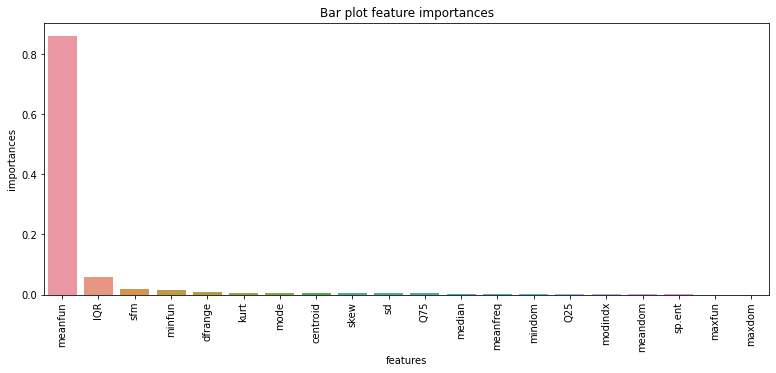

In [46]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
features = X.columns #признаки
feature_importances = best_tree.feature_importances_ #важность признаков
# Создаём DataFrame, содержащий информацию о важности признаков
importances_data = pd.DataFrame({'features': features, 'importances': feature_importances})
importances_data = importances_data.sort_values(by='importances', ascending=False)
# Строим столбчатую диаграмму
sns.barplot(data=importances_data, x='features', y='importances', ax=ax);
# Добавляем подпись к графику и поворот меток на оси абсцисс
ax.set_title('Bar plot feature importances')
ax.xaxis.set_tick_params(rotation=90)

MATH&ML-9. Математика ансамблевых методо

2.7 Объёмная и содержательная практика у нас ещё впереди, но в качестве разминки давайте поработаем с уже известным вам датасетом о вине, который можно скачать здесь.

Ранее вы обучали на данных только один алгоритм, а теперь мы попробуем сравнить несколько.

Подготовьте данные к классификации. Условно разделите вино на хорошее и плохое. Хорошим вином будем называть то, параметр quality которого — 6 и более.
Сравните несколько методов классификации: логистическую регрессию, дерево решений и бэггинг. Это позволит вам увидеть, как меняется качество в зависимости от выбора того или иного алгоритма.
Разделите выборку на обучающую и тестовую в соотношении 70/30, в качестве значения параметра random_state возьмите число 42.
Для начала обучите два классификатора: логистическую регрессию (с параметрами по умолчанию) и дерево решений (random_state = 42, максимальная глубина — 10).

In [49]:

from sklearn.model_selection import train_test_split
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [54]:
df= pd.read_csv("data/winequality-red.csv",sep=';')


In [55]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [57]:
df['target']= np.where(df.quality >=6,1,0)
Y= df['target']
X = df.drop(['target', 'quality'], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
f1_score(preds_test, y_test)


/Users/sev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7528517110266161

In [58]:
model = DecisionTreeClassifier(max_depth = 10, random_state=42)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
f1_score(preds_test, y_test)

0.7927927927927927

2.8 Обучите модель с использованием бэггинга (класс BaggingClassifier с random_state=42).

Возьмите из предыдущего задания алгоритм, показавший наилучшее качество, и укажите для него новое количество моделей — 1500. Вычислите новое значение F1-score.

In [59]:
from sklearn.ensemble import BaggingClassifier

In [60]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 10, random_state=42), n_estimators=1500, random_state=42).fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
f1_score(preds_test, y_test)

0.8181818181818181

3.4  1. Разбейте набор данных на обучающую и тестовую выборку в соотношении 70/30, при разбиении задайте параметр random_state = 13.

In [81]:
df= pd.read_csv("data/boston1.csv",sep=',',decimal=',')

In [82]:
df.head()

,crim_rate,zn,business,river,nit_oxiden,rooms,age,dist,highways_index,tax,pup_per_teaс,lower,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [83]:
Y= df['target']
X = df.drop(['target'], axis= 1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=13)

In [85]:
y_train.median()

21.55

In [91]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

Обучите линейную регрессию с параметрами по умолчанию.

In [92]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

preds_train = model_lr.predict(X_train)
preds_test = model_lr.predict(X_test)

print(mean_absolute_error(y_test, preds_test))

3.7222793958561446


Обучите решающее дерево с параметрами по умолчанию и аргументом random_state = 13.

In [94]:
from sklearn.tree import DecisionTreeRegressor

In [97]:
model = DecisionTreeRegressor(random_state=13)
model.fit(X_train, y_train)

preds_train = model.predict(X_train)
preds_test = model.predict(X_test)


print(mean_absolute_error(y_train, preds_train))
print(mean_absolute_error(y_test, preds_test))

0.0
2.8388157894736845


4. Обучите четыре случайных леса с числом деревьев 3, 10, 100, 500 и параметром random_state = 13.

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
for n in [3, 10, 100, 500]:
    model = RandomForestRegressor(n_estimators=n, random_state = 13)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    print(mean_absolute_error(y_test, preds_test))

2.9328947368421057
2.466315789473684
2.2559736842105265
2.2365657894736892
